Data Preparation

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import requests # reading data
from io import StringIO
from sklearn.datasets import fetch_openml # common data set access
from sklearn.preprocessing import StandardScaler # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss as J01
import sklearn.tree as tree
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import learning_curve


adult = fetch_ucirepo(id=2)
X_original = adult.data.features
y_original = adult.data.targets
X_age = np.array(X_original)[:20000,0]
X_wh = np.array(X_original)[:20000,12]
X = np.column_stack((X_age, X_wh))
y = np.array(y_original)[:20000]

y_cleaned = np.array([label[0].replace('.', '') for label in y])
encoder = LabelEncoder()
y = encoder.fit_transform(y_cleaned)
X = pd.DataFrame(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = 2*y - 1

X_age = np.array(X_original)[:20000,0]  # age
X_edu = np.array(X_original)[:20000,4]  # education-num
X_sex = np.array(X_original)[:20000,9]  # sex
X_hours = np.array(X_original)[:20000,12]  # hours-per-week
X_marital = np.array(X_original)[:20000,5]  # marital-status
X_selected = np.column_stack((X_age, X_edu, X_sex, X_hours, X_marital))
X_selected = pd.DataFrame(X_selected, columns=['age', 'education-num', 'sex', 'hours-per-week', 'marital-status'])

label_encoder = LabelEncoder()
X_selected['sex'] = label_encoder.fit_transform(X_selected['sex'])
X_selected['marital-status'] = label_encoder.fit_transform(X_selected['marital-status'])

scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.3, random_state=42)

Random Forest

In [38]:
rf = RandomForestClassifier(n_estimators=100,max_depth=10,class_weight='balanced',random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(classification_report(
    y_test, y_pred_rf,
    labels=[-1, 1],
    target_names=encoder.classes_
))

Random Forest Results:
Accuracy: 0.778
              precision    recall  f1-score   support

       <=50K       0.94      0.76      0.84      4566
        >50K       0.52      0.84      0.64      1434

    accuracy                           0.78      6000
   macro avg       0.73      0.80      0.74      6000
weighted avg       0.84      0.78      0.79      6000



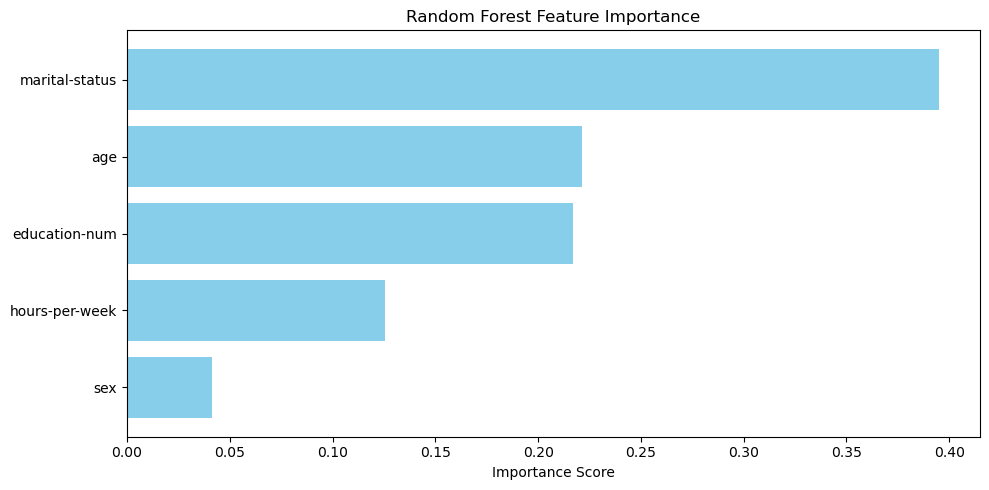

In [35]:
feature_names = X_selected.columns.tolist()
importances = rf.feature_importances_

plt.figure(figsize=(10, 5))
sorted_idx = np.argsort(importances)
plt.barh(range(len(feature_names)), importances[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(feature_names)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance Score")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

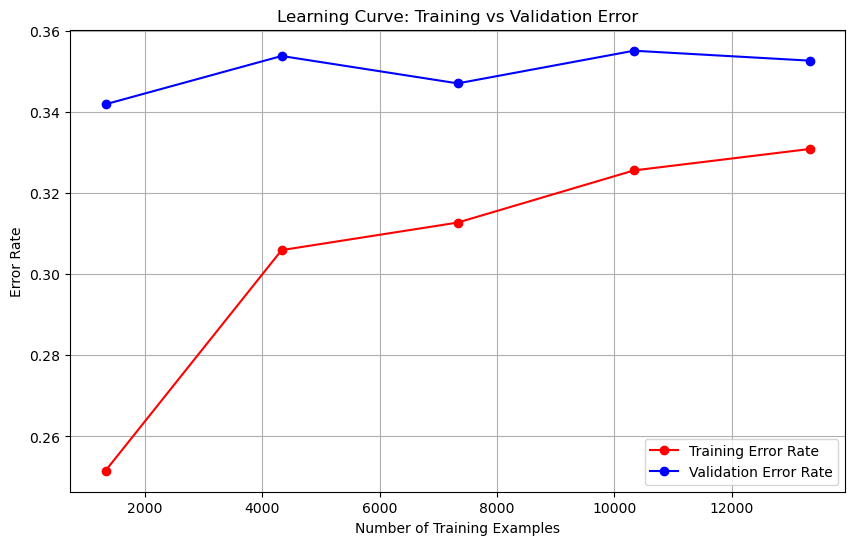

In [44]:

train_sizes, train_scores, val_scores = learning_curve(
    estimator=rf,
    X=X,
    y=y,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),  # 10%, 25%, 50%, 75%, 100% of training data
    n_jobs=-1
)


train_errors = 1 - np.mean(train_scores, axis=1)
val_errors = 1 - np.mean(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, 'o-', color="red", label="Training Error Rate")
plt.plot(train_sizes, val_errors, 'o-', color="blue", label="Validation Error Rate")
plt.xlabel("Number of Training Examples")
plt.ylabel("Error Rate")
plt.title("Learning Curve: Training vs Validation Error")
plt.legend()
plt.grid(True)
plt.show()